In [2]:
import pandas as pd
import numpy as np
import torch
import dgl

# 构造一个基因ID映射到Node ID的表格

In [12]:
df_expr = pd.read_table('./data/GBM.expression.tsv.gz', compression='gzip')
df_expr = df_expr.sort_values('attrib_name').reset_index(drop=True)
id_mapping = df_expr[['attrib_name']].reset_index(drop=False)
id_mapping.columns = ['node_id', 'gene_id']
id_mapping = id_mapping.set_index('gene_id')
id_mapping

,node_id
gene_id,
2,0
10,1
12,2
13,3
14,4
...,...
727897,8569
100287932,8570
100505741,8571


# 读取STRING数据，并构建Graph

In [18]:
df_string = pd.read_csv('./data/string.csv.gz', compression='gzip')
df_string = df_string[(df_string.src.isin(id_mapping.index.values)) & ((df_string.dest.isin(id_mapping.index.values)))]
df_string

,src,dest,score
0,381,5137,155
1,381,5062,197
2,381,9609,222
3,381,2889,181
4,381,6612,270
...,...,...,...
10862291,158,10539,206
10862292,158,2026,174
10862293,158,5137,915
10862294,158,7378,425


In [19]:
# ID 映射
df_string.src = df_string.src.map(lambda x: id_mapping.loc[x, 'node_id'])
df_string.dest = df_string.dest.map(lambda x: id_mapping.loc[x, 'node_id'])
df_string

,src,dest,score
0,214,2592,155
1,214,2547,197
2,214,4834,222
3,214,1506,181
4,214,3449,270
...,...,...,...
10862291,87,5374,206
10862292,87,1091,174
10862293,87,2592,915
10862294,87,3893,425


In [91]:
# df_string = df_string.astype('int')
g = dgl.graph((df_string.src.to_list(), df_string.dest.to_list()))
# add edge feature
score = torch.tensor(df_string.score.values, dtype=torch.float16) / 100
score = score.reshape(-1,1)
g.edata['e'] = score

# 读取表达数据

In [22]:
df_expr = pd.read_table('./data/GBM.expression.tsv.gz', compression='gzip')
df_expr = df_expr.sort_values('attrib_name')
df_expr = df_expr.set_index('attrib_name')

df_expr

,TCGA.12.3652,TCGA.19.0960,TCGA.12.1099,TCGA.06.0130,TCGA.02.0028,TCGA.28.1750,TCGA.32.2616,TCGA.06.2564,TCGA.16.1056,TCGA.19.2623,...,TCGA.12.1091,TCGA.06.2570,TCGA.32.1986,TCGA.19.2629,TCGA.14.1795,TCGA.27.2524,TCGA.02.0074,TCGA.02.0057,TCGA.06.0876,TCGA.28.1747
attrib_name,,,,,,,,,,,,,,,,,,,,,
2,10.5979,10.4630,10.8536,11.3115,12.2441,11.4064,11.2551,11.4550,11.3490,12.0571,...,10.5227,11.3052,11.8889,12.1679,10.5943,11.1709,11.5278,9.3453,11.6501,11.5307
10,4.3600,4.0485,4.3933,4.2381,4.6189,4.1182,4.3167,4.1471,4.8170,5.4902,...,4.1550,4.4206,4.1043,5.4821,4.1064,4.2090,4.1220,4.3535,4.7138,4.7232
12,12.6358,10.2682,10.9521,10.7356,7.4782,12.3590,9.7922,12.6403,11.6577,12.1217,...,11.2099,11.8301,12.1437,11.2118,11.3663,12.8681,12.0490,7.7153,12.7560,13.3621
13,4.4409,4.4866,4.0608,4.1486,6.2149,4.0715,4.1651,4.1576,4.1742,4.2945,...,4.0886,4.2983,4.2961,4.3445,4.2925,4.1945,4.3520,5.9844,4.2401,4.3045
14,8.2369,7.5124,6.9577,7.3419,7.0865,7.4586,7.8544,7.7549,7.6203,8.0529,...,7.9003,7.6223,7.7544,8.5009,7.3601,7.9854,7.4998,8.5380,7.6897,7.9871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727897,3.9537,4.1013,3.9438,4.0010,4.2555,3.8334,3.9041,3.8099,3.8697,3.8689,...,3.9129,3.9279,3.9145,3.8667,3.9359,4.0227,3.9233,4.0281,3.9951,3.8025
100287932,7.2568,6.7077,6.2621,7.6922,7.0344,6.5309,7.8562,7.2160,6.7103,7.2548,...,6.5788,7.5650,7.3479,7.7499,6.7340,7.6765,7.0724,7.1052,6.7071,7.2291
100505741,5.8831,4.1190,3.8957,4.2657,3.8111,3.8543,3.9569,4.2096,3.8134,4.2256,...,3.9601,4.0750,4.0837,3.8337,3.6762,4.2795,3.2886,3.5057,3.9485,3.7876


# 读取CNV数据

In [26]:
df_cnv = pd.read_table('./data/GBM.cnv.tsv.gz', compression='gzip')
df_cnv = df_cnv.sort_values('attrib_name').set_index('attrib_name')
df_cnv

,TCGA.12.3652,TCGA.19.0960,TCGA.12.1099,TCGA.06.0130,TCGA.02.0028,TCGA.28.1750,TCGA.32.2616,TCGA.06.2564,TCGA.16.1056,TCGA.19.2623,...,TCGA.12.1091,TCGA.06.2570,TCGA.32.1986,TCGA.19.2629,TCGA.14.1795,TCGA.27.2524,TCGA.02.0074,TCGA.02.0057,TCGA.06.0876,TCGA.28.1747
attrib_name,,,,,,,,,,,,,,,,,,,,,
2,-0.027,-0.920,-0.047,0.023,0.001,0.009,0.002,0.000,-0.024,-0.788,...,0.015,-0.730,0.005,0.090,0.002,-0.003,0.134,0.005,0.026,0.007
10,0.029,-0.178,0.288,-0.053,-0.002,-0.352,-0.002,-0.004,-0.767,-0.070,...,-0.940,-0.874,-0.030,0.082,-0.004,-0.772,0.172,0.002,0.021,0.010
12,-0.043,0.019,-0.063,-0.278,0.010,-0.502,-0.863,0.014,0.017,-0.740,...,-0.930,-0.003,0.013,-0.841,0.009,0.002,-0.733,-0.027,-0.114,0.003
13,0.017,0.000,1.063,-0.033,0.834,0.002,-0.011,-0.004,0.004,0.021,...,-0.001,0.049,-0.019,0.104,-0.003,0.007,0.193,0.000,0.021,0.003
14,0.010,-0.011,-0.210,-0.037,-0.011,0.000,-0.019,0.005,0.000,-0.068,...,-0.034,-0.014,0.009,0.037,-0.005,-0.007,-0.244,0.005,-0.028,-0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727897,-0.024,0.052,-0.182,0.116,0.019,0.030,0.038,0.003,0.016,-0.806,...,0.032,-0.853,0.005,0.130,0.000,0.020,-0.284,-0.001,-0.084,-0.006
100287932,-1.081,-0.101,0.060,-0.277,0.003,-0.492,-0.062,-0.751,-0.751,-0.804,...,-0.926,-0.043,-0.212,-0.810,-0.721,-0.778,-0.846,-0.383,-0.486,-0.815
100505741,-0.004,-0.006,0.262,0.107,-0.904,0.006,0.035,-0.001,0.011,0.034,...,0.017,0.010,0.012,-0.201,0.001,-0.044,-0.011,-0.014,-0.029,0.000


# 读取甲基化数据

In [27]:
df_met = pd.read_table('./data/GBM.met.tsv.gz', compression='gzip')
df_met = df_met.sort_values('attrib_name').set_index('attrib_name')
df_met

,TCGA.12.3652,TCGA.19.0960,TCGA.12.1099,TCGA.06.0130,TCGA.02.0028,TCGA.28.1750,TCGA.32.2616,TCGA.06.2564,TCGA.16.1056,TCGA.19.2623,...,TCGA.12.1091,TCGA.06.2570,TCGA.32.1986,TCGA.19.2629,TCGA.14.1795,TCGA.27.2524,TCGA.02.0074,TCGA.02.0057,TCGA.06.0876,TCGA.28.1747
attrib_name,,,,,,,,,,,,,,,,,,,,,
2,-0.3239,-0.2002,0.0783,0.0910,-0.1615,0.1317,-0.2341,-0.2402,-0.1220,0.0272,...,-0.1347,0.3366,-0.1999,0.0387,0.3687,0.0215,0.1791,-0.0251,-0.1002,-0.2012
10,0.4088,0.3564,0.1996,0.3912,0.4263,0.4174,0.4247,0.4378,0.3992,0.4262,...,0.3876,0.4384,0.4316,0.4244,0.3038,0.4201,0.4185,0.4025,0.4065,0.4478
12,-0.3186,-0.3671,-0.2790,0.0834,-0.2883,-0.0036,0.0953,-0.2876,-0.2894,-0.0668,...,-0.1525,-0.0911,0.0232,0.0680,-0.0159,-0.3197,-0.0842,-0.0897,-0.1135,-0.0312
13,0.3497,0.0222,0.4349,0.4542,0.4414,0.4612,0.4299,0.4394,0.4572,0.4186,...,0.4079,0.4228,0.4661,0.4178,0.4134,0.4618,0.4461,0.4552,0.4325,0.4329
14,-0.4834,-0.4859,-0.4858,-0.4792,-0.4776,-0.4831,-0.4875,-0.4821,-0.4823,-0.4839,...,-0.4854,-0.4832,-0.4829,-0.4859,-0.4874,-0.4814,-0.4712,-0.4767,-0.4846,-0.4806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727897,-0.0002,-0.0630,0.2128,0.1241,0.3083,-0.0421,-0.2066,0.2139,-0.0090,0.2157,...,0.1822,0.0418,0.1859,0.2578,0.1819,0.2718,-0.0156,0.2605,0.2463,0.1820
100287932,-0.4575,-0.4772,-0.4747,-0.4506,-0.4542,-0.4393,-0.4739,-0.4740,-0.4613,-0.4613,...,-0.4687,-0.4751,-0.4730,-0.4643,-0.4802,-0.4692,-0.4393,-0.4577,-0.4629,-0.4701
100505741,-0.4753,-0.4784,-0.4789,-0.4486,-0.4243,-0.4702,-0.4753,-0.4803,-0.4760,-0.4757,...,-0.4765,-0.4720,-0.4763,-0.4596,-0.4811,-0.4762,-0.4341,-0.4349,-0.4698,-0.4826


# 读取临床数据

In [113]:
df_clin = pd.read_table('./data/raw/GBM/Clinical.tsi')
df_clin = df_clin.T
cols = df_clin.iloc[0,:]
df_clin = df_clin.iloc[1:, :]
df_clin.columns = cols
df_clin = df_clin.loc[df_met.columns, :]

df_clin.overall_survival = df_clin.overall_survival.astype('int')
df_clin.status = df_clin.status.astype('int')
df_clin.loc[(df_clin.overall_survival < 2*365) & (df_clin.status == 1), 'label'] = 1
df_clin.loc[(df_clin.overall_survival >= 2*365), 'label'] = 0
df_clin = df_clin[~df_clin.label.isna()]

In [116]:
df_clin.label.value_counts()

1.0    170
0.0     50
Name: label, dtype: int64

# 构建图特征

In [46]:
omics_[0]

,gene,TCGA.12.3648,TCGA.19.1385,TCGA.14.1459,TCGA.12.3644,TCGA.41.3392,TCGA.32.4210,TCGA.19.1390,TCGA.12.0821,TCGA.16.0850,...,TCGA.06.0125,TCGA.12.1098,TCGA.16.0846,TCGA.12.1089,TCGA.41.2575,TCGA.14.0871,TCGA.32.1978,TCGA.19.0963,TCGA.02.0058,TCGA.27.2524
0,0,0.000,-0.247,0.001,-0.010,0.029,0.258,-0.438,-0.012,-0.486,...,-0.003,0.815,0.000,0.005,0.043,-0.110,-0.439,0.004,0.083,-0.003
1,1,0.004,-0.263,0.009,0.013,0.004,-0.274,0.074,-0.029,0.042,...,0.000,-0.902,-0.224,-0.001,0.002,0.398,0.205,0.007,0.000,-0.772
2,2,-0.012,0.010,0.012,0.001,-0.217,-0.023,-0.972,-0.816,0.041,...,-0.049,0.001,0.205,-0.812,-1.100,-0.004,0.011,0.022,-0.832,0.002
3,3,0.004,0.000,0.040,1.158,-0.004,0.021,0.078,0.017,0.091,...,0.015,-0.005,0.091,-0.805,-0.013,-0.435,0.000,-0.017,-0.075,0.007
4,4,-0.001,0.003,-0.011,0.006,-0.015,0.148,-0.402,0.000,-0.449,...,0.006,-0.013,0.250,0.012,-0.014,-0.085,-0.106,-0.004,0.007,-0.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8240,8240,-0.173,0.006,0.026,-0.055,0.009,-0.509,0.196,0.113,-0.027,...,-0.019,0.815,0.194,0.006,0.148,-0.351,0.042,0.048,0.020,-0.122
8241,8241,-0.021,0.009,-0.237,-0.053,0.001,-0.234,-0.454,-0.018,-1.018,...,-0.026,0.001,-0.355,-0.025,-0.008,-0.763,0.010,-0.030,-0.545,0.020
8242,8242,-1.107,-0.252,-0.901,-1.014,-0.963,-0.537,0.014,-0.823,-1.039,...,-0.913,-0.007,-0.061,0.020,-1.053,-1.144,-0.960,-0.699,0.000,-0.778
8243,8243,0.004,-0.004,-0.008,0.014,0.010,0.175,0.051,-0.084,-1.023,...,0.013,0.774,0.035,-0.007,0.000,-0.804,0.005,-0.010,0.005,0.004


In [119]:
df_cnv = df_cnv[df_clin.index]
df_met = df_met[df_clin.index]
df_expr = df_expr[df_clin.index]

In [130]:
import torch
omics_tensor = []
for omic in omics_:
    omics_tensor.append(torch.tensor(omics_[0].iloc[:, 1:].values, dtype=torch.float32).unsqueeze(2))
multi_omics = torch.stack(omics_tensor, 2).squeeze(3)
print(multi_omics.shape)

torch.Size([8245, 220, 3])


In [59]:
df_clin = pd.read_csv('./data/GBM/clinincal.csv')
df_clin

,patient_id,label,feature_age,feature_tumor_purity,feature_histological_type_glioblastomamultiforme(gbm),feature_histological_type_treatedprimarygbm,feature_histological_type_untreatedprimary(denovo)gbm,feature_gender_female,feature_gender_male,feature_radiation_therapy_no,feature_radiation_therapy_yes,feature_race_asian,feature_race_blackorafricanamerican,feature_race_white,feature_ethnicity_hispanicorlatino,feature_ethnicity_nothispanicorlatino
0,TCGA.06.6391,1.0,44,0.8360,0,0,1,1,0,1,0,0,0,1,0,1
1,TCGA.19.A6J4,1.0,68,0.6736,1,0,0,0,1,0,0,0,1,0,0,1
2,TCGA.06.1806,1.0,47,0.7913,1,0,0,0,1,0,1,0,0,1,0,1
3,TCGA.06.5408,1.0,54,0.8635,0,0,1,1,0,0,1,0,0,1,0,1
4,TCGA.06.5410,1.0,72,0.3396,0,0,1,1,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,TCGA.76.6280,1.0,57,0.8776,0,0,1,0,1,0,1,0,0,1,0,1
490,TCGA.76.6283,1.0,71,0.9779,1,0,0,1,0,0,0,0,0,1,0,1
491,TCGA.76.6660,1.0,73,0.7707,1,0,0,0,1,0,0,0,0,1,0,1
492,TCGA.81.5910,1.0,64,0.7913,0,0,1,0,1,1,0,0,0,1,0,0


In [131]:
G = []
labels = []
for i in range(multi_omics.shape[1]):
    # step1: build graphs
    g = dgl.graph((df_ppi.src.to_list(), df_ppi.dest.to_list()))
    # add edge feature
    score = torch.tensor(df_ppi.score.values) / 100
    score = score.reshape(-1,1)
    g.edata['e'] = score
    # add node feature
    g.ndata['h'] = multi_omics[:,i,:]
#     g.ndata['c'] = clin_features[i]
    G.append(g)
    
    # step2: get labels
    label = df_clin.label.values[i]
    labels.append(label)

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 31211408 bytes.

In [107]:
len(G), len(labels)

(220, 220)

In [86]:
df_clin = df_clin[df_clin.patient_id.isin(omics_[0].columns[1:].values)].reset_index(drop=True)
df_clin

,patient_id,label,feature_age,feature_tumor_purity,feature_histological_type_glioblastomamultiforme(gbm),feature_histological_type_treatedprimarygbm,feature_histological_type_untreatedprimary(denovo)gbm,feature_gender_female,feature_gender_male,feature_radiation_therapy_no,feature_radiation_therapy_yes,feature_race_asian,feature_race_blackorafricanamerican,feature_race_white,feature_ethnicity_hispanicorlatino,feature_ethnicity_nothispanicorlatino
0,TCGA.12.1092,1.0,58,0.7653,0,0,1,0,1,0,1,0,0,1,0,1
1,TCGA.12.1598,1.0,75,0.9403,0,0,1,1,0,0,1,0,0,1,0,1
2,TCGA.12.1599,0.0,47,0.8807,0,0,1,1,0,0,1,0,0,1,0,1
3,TCGA.12.1600,1.0,86,0.8956,0,0,1,0,1,0,1,0,0,1,0,1
4,TCGA.12.1602,1.0,58,0.9058,0,0,1,0,1,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,TCGA.19.1385,1.0,69,0.6349,0,0,1,0,1,0,1,0,0,1,0,1
216,TCGA.19.1386,1.0,51,0.9627,0,0,1,0,1,0,1,0,0,1,0,1
217,TCGA.19.1388,1.0,58,0.8746,0,0,1,0,1,0,1,0,0,1,0,1
218,TCGA.19.1389,1.0,51,NaN,0,0,1,0,1,0,1,0,0,1,0,1


In [98]:
clin_features = torch.tensor(df_clin.iloc[:, 2:].values).unsqueeze(2)
clin_features[1]

tensor([[75.0000],
        [ 0.9403],
        [ 0.0000],
        [ 0.0000],
        [ 1.0000],
        [ 1.0000],
        [ 0.0000],
        [ 0.0000],
        [ 1.0000],
        [ 0.0000],
        [ 0.0000],
        [ 1.0000],
        [ 0.0000],
        [ 1.0000]], dtype=torch.float64)

In [91]:
omics_tensor = []
for omic in omics_:
    omics_tensor.append(torch.tensor(omic.loc[:, df_clin.patient_id.values].values).unsqueeze(2))
multi_omics = torch.stack(omics_tensor, 2).squeeze(3)

multi_omics.shape

torch.Size([8245, 220, 3])

In [87]:
df_clin.patient_id.values

array(['TCGA.12.1092', 'TCGA.12.1598', 'TCGA.12.1599', 'TCGA.12.1600',
       'TCGA.12.1602', 'TCGA.12.3644', 'TCGA.12.3646', 'TCGA.12.3648',
       'TCGA.12.3649', 'TCGA.12.3650', 'TCGA.12.3651', 'TCGA.12.3652',
       'TCGA.12.3653', 'TCGA.14.0736', 'TCGA.14.0783', 'TCGA.14.0786',
       'TCGA.14.0790', 'TCGA.14.0812', 'TCGA.14.0865', 'TCGA.14.0866',
       'TCGA.14.1034', 'TCGA.14.1396', 'TCGA.14.1401', 'TCGA.14.1402',
       'TCGA.14.1451', 'TCGA.14.1452', 'TCGA.14.1453', 'TCGA.14.1454',
       'TCGA.14.1456', 'TCGA.14.1458', 'TCGA.14.1459', 'TCGA.14.1794',
       'TCGA.14.1795', 'TCGA.14.1821', 'TCGA.14.1823', 'TCGA.14.1825',
       'TCGA.14.1827', 'TCGA.14.2554', 'TCGA.16.0848', 'TCGA.16.1045',
       'TCGA.16.1047', 'TCGA.16.1055', 'TCGA.16.1056', 'TCGA.16.1060',
       'TCGA.16.1062', 'TCGA.16.1063', 'TCGA.19.0963', 'TCGA.19.1390',
       'TCGA.19.1392', 'TCGA.19.1787', 'TCGA.19.1789', 'TCGA.19.2620',
       'TCGA.19.2621', 'TCGA.19.2625', 'TCGA.19.2629', 'TCGA.19.2631',
      

# code test

In [3]:
from util import clin_process_tsi

clin_process_tsi(in_file='./data/GBM/Clinical.tsi', out_file='./data/GBM/clinincal.csv')

In [4]:
from data import read_omics, read_clin
omics_files = ['./data/GBM/GBM.cnv.csv.gz', './data/GBM/GBM.expression.csv.gz', './data/GBM/GBM.met.csv.gz']
omics = read_omics(omics_files=omics_files, clin_file= './data/GBM/clinincal.csv')

In [5]:
from data import build_graph

G, labels, clin_features = build_graph(omics=omics, clinical_file='./data/GBM/clinincal.csv')


[INFO] The overlaping genes number between omics and ppi dataset is: 8245


In [8]:
g.is_homogeneous

True

In [4]:
import pandas as pd
df_ppi = pd.concat([pd.read_csv('./data/PPI/ppi_1.csv.gz', compression='gzip'),
                    pd.read_csv('./data/PPI/ppi_2.csv.gz', compression='gzip'),
                    pd.read_csv('./data/PPI/ppi_3.csv.gz', compression='gzip')
                   ]).reset_index(drop=True)

# 构建GNN图

In [108]:
# G 
# labels

In [110]:
import dgl.nn.pytorch as dglnn
import torch.nn as nn
import torch.nn.functional as F

In [111]:
class Net(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Net, self).__init__()
        self.conv1 = dglnn.GraphConv(in_dim, hidden_dim)
        self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)
    
    def forward(self, g, h):
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        with g.local_scope():
            g.ndata['h'] = h
            hg = dgl.mean_nodes[g, 'h']
            return self.classify(hg)

In [12]:
labels

torch.Size([220])

In [13]:
from dgl.dataloading import GraphDataLoader

def _collate_fn(batch):
    print(batch)
    graphs, labels = batch
    g = dgl.batch(graphs)
    labels = torch.tensor(labels, dtype=torch.long)
    return g, label

# 创建 dataloaders
dataloader = GraphDataLoader((G, labels), batch_size=3, shuffle=True, collate_fn=_collate_fn)

for g, l in dataloader:
#     print(g)
    break

[tensor([1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1]), [Graph(num_nodes=8245, num_edges=3901426,
      ndata_schemes={'h': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(1,), dtype=torch.float32)}), Graph(num_nodes=8245, num_edges=3901426,
      ndata_schemes={'h': Scheme(shape

AttributeError: 'Tensor' object has no attribute 'is_block'

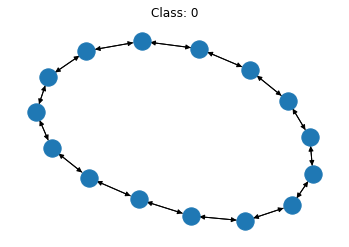

In [76]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
# 数据集包含了80张图。每张图有10-20个节点
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

In [78]:
import torch.optim as optim
from torch.utils.data import DataLoader

# 创建一个训练数据集和测试数据集
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
trainset

Dataset("minigc", num_graphs=320, save_path=/home/PJLAB/liangbilin/.dgl/minigc)

In [80]:
trainset.labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

In [85]:
graphs, labels = zip(*[trainset[i] for i in range(16)])
batched_graphs = dgl.batch(graphs)
batched_labels = torch.tensor(labels)
batched_graphs, batched_labels

(Graph(num_nodes=237, num_edges=711,
       ndata_schemes={}
       edata_schemes={}),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [94]:
dgl.batch(G[:3]),  labels[:3]

(Graph(num_nodes=24735, num_edges=11704278,
       ndata_schemes={'h': Scheme(shape=(3,), dtype=torch.float32)}
       edata_schemes={'e': Scheme(shape=(1,), dtype=torch.float32)}),
 (tensor(0), tensor(0), tensor(0)))

# Net

In [43]:
from dgl.data import DGLDataset
from data import build_graph

class MyDataset(DGLDataset):
    """ 用于在DGL中自定义图数据集的模板：

    Parameters
    ----------
    url : str
        下载原始数据集的url。
    raw_dir : str
        指定下载数据的存储目录或已下载数据的存储目录。默认: ~/.dgl/
    save_dir : str
        处理完成的数据集的保存目录。默认：raw_dir指定的值
    force_reload : bool
        是否重新导入数据集。默认：False
    verbose : bool
        是否打印进度信息。
    """
    def __init__(self,
                 url=None,
                 raw_dir=None,
                 save_dir=None,
                 force_reload=False,
                 verbose=False):
        super(MyDataset, self).__init__(name='dataset_name',
                                        url=url,
                                        raw_dir=raw_dir,
                                        save_dir=save_dir,
                                        force_reload=force_reload,
                                        verbose=verbose)

    def download(self):
        # 将原始数据下载到本地磁盘
        pass

    def process(self):
        # 将原始数据处理为图、标签和数据集划分的掩码
        self.graphs, self.label, self.clin = build_graph(omics=omics, clinical_file='./data/GBM/clinincal.csv')

    def __getitem__(self, idx):
        return self.graphs[idx], self.label[idx], self.clin[idx]

    def __len__(self):
        return len(self.graphs)

    def save(self):
        # 将处理后的数据保存至 `self.save_path`
        pass

    def load(self):
        # 从 `self.save_path` 导入处理后的数据
        pass

    def has_cache(self):
        # 检查在 `self.save_path` 中是否存有处理后的数据
        pass
    
mydataset = MyDataset()


[INFO] The overlaping genes number between omics and ppi dataset is: 8245


In [17]:
from dgl.dataloading import GraphDataLoader

# G, labels

def _collate_fn(batch):
    print(batch)
    print('--')
#     print(batch[0])
#     print('--')
#     print(batch[0][1])
#     print('-----')
#     g, l = zip(*batch)
#     print(g,l)
#     print('++++')
#     print(dgl.batch(g))
#     print(torch.tensor(l))
#     print('++++')
    graphs, labels, clin = zip(*batch)  # clinical feature 暂时不用
    g = dgl.batch(graphs)
    labels = torch.tensor(labels, dtype=torch.long)
    return g, labels

# 创建 dataloaders
dataloader = GraphDataLoader((G,labels), batch_size=3, shuffle=True, collate_fn=_collate_fn)

for graphs, labels in dataloader:
    print(graphs, labels)
    break

[[Graph(num_nodes=8245, num_edges=3901426,
      ndata_schemes={'h': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(1,), dtype=torch.float32)}), Graph(num_nodes=8245, num_edges=3901426,
      ndata_schemes={'h': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(1,), dtype=torch.float32)}), Graph(num_nodes=8245, num_edges=3901426,
      ndata_schemes={'h': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(1,), dtype=torch.float32)}), Graph(num_nodes=8245, num_edges=3901426,
      ndata_schemes={'h': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(1,), dtype=torch.float32)}), Graph(num_nodes=8245, num_edges=3901426,
      ndata_schemes={'h': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(1,), dtype=torch.float32)}), Graph(num_nodes=8245, num_edges=3901426,
      ndata_schemes={'h': Scheme(shape=(3,), dtype=torch.float32)}
     

ValueError: too many values to unpack (expected 3)

In [73]:
import dgl.nn.pytorch as dglnn
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = dglnn.GraphConv(in_dim, hidden_dim)
        self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h):
        # 应用图卷积和激活函数
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        with g.local_scope():
            g.ndata['h'] = h
            # 使用平均读出计算图表示
            hg = dgl.mean_nodes(g, 'h')
            return self.classify(hg)

In [77]:
graphs.ndata['h'][0:5]

tensor([[-1.6000e-02,  1.2698e+01, -2.4240e-01],
        [-4.2100e-01,  4.9417e+00,  4.0100e-01],
        [-8.0000e-03,  1.2877e+01, -1.5800e-01],
        [ 1.2000e-02,  4.2071e+00,  4.7430e-01],
        [ 0.0000e+00,  7.9748e+00, -4.8580e-01]])

In [1]:
model = Classifier(in_dim=3, hidden_dim=8, n_classes=2)

opt = torch.optim.Adam(model.parameters())
for epoch in range(20):
    for batched_graph, labels in dataloader:
        feats = batched_graph.ndata['h']
        logits = model(batched_graph, feats)
        loss = F.cross_entropy(logits, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        print('Epoch {:2d} | Loss {:.5f}'.format(epoch, loss.item()))

NameError: name 'torch' is not defined